---

We investigate the COS method as described in the paper by 
[Fang and Oosterlee (2008)](https://doi.org/10.1137/080718061).

---

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

### Imports

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)

SEED = 1234  # for reproducibility

### PDF of the normal distribution from Characteristic Function

We reproduce the results from Example 6.1.1 of 
[Cornelis and Oosterlee (2019)](https://doi.org/10.1142/q0236 ).

Write the PDF and CF of the standard normal distribution as

$$
    f_{\mathcal{N}(0, 1)}(x) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{x^2}{2}\right),
    \qquad
    \phi_{\mathcal{N}(0, 1)}(u) = \exp\left(-\frac{u^2}{2}\right)
$$

In [ ]:
def pdf_normal(x, mu=0.0, sigma=1.0):
    """PDF of the normal distribution X ~ N(mu, sigma^2)."""
    return stats.norm.pdf(x, loc=mu, scale=sigma)


def cf_normal(u, mu=0.0, sigma=1.0):
    """Characteristic function of the normal distribution X ~ N(mu, sigma^2)."""
    return np.exp(-0.5 * (u * sigma) ** 2 + 1j * mu * u)

In [ ]:
a = -10
b = 10
x = np.linspace(a, b, 501)


def pdf_normal_cos_method(x, N, mu=0.0, sigma=1.0):
    """PDF of the normal distribution X ~ N(mu, sigma^2) using the cosine method."""
    k = np.arange(N)
    F_k = (
        2
        / (b - a)
        * np.real(
            cf_normal(k * np.pi / (b - a), mu=mu, sigma=sigma)
            * np.exp(-1j * k * np.pi * a / (b - a))
        )
    )
    cos_k = np.cos(np.pi * k[None, :] * (x[:, None] - a) / (b - a))
    F_k[0] *= 0.5  # first term is halved
    return np.sum(F_k[None, :] * cos_k, axis=1)

In [ ]:
def pdf_cos_method(x, N, f_cf, a, b):
    """
    Compute a PDF using the COS (cosine) method.

    Parameters
    ----------
    x : array_like
        1-D array of points where the PDF is evaluated.
    N : int
        Number of cosine series terms (truncation parameter).
    f_cf : callable
        Characteristic function phi(u) of the distribution. Must accept a
        numpy array of real frequencies and return complex values.
    a, b : float
        Integration interval [a, b] used for the COS expansion.

    Returns
    -------
    pdf : ndarray
        1-D array of estimated PDF values corresponding to x.
    """
    k = np.arange(N)
    factor = np.exp(-1j * k * np.pi * a / (b - a))
    F_k = 2 / (b - a) * np.real(f_cf(k * np.pi / (b - a)) * factor)
    cos_k = np.cos(np.pi * k[None, :] * (x[:, None] - a) / (b - a))
    F_k[0] *= 0.5  # first term is halved
    return np.sum(F_k[None, :] * cos_k, axis=1)

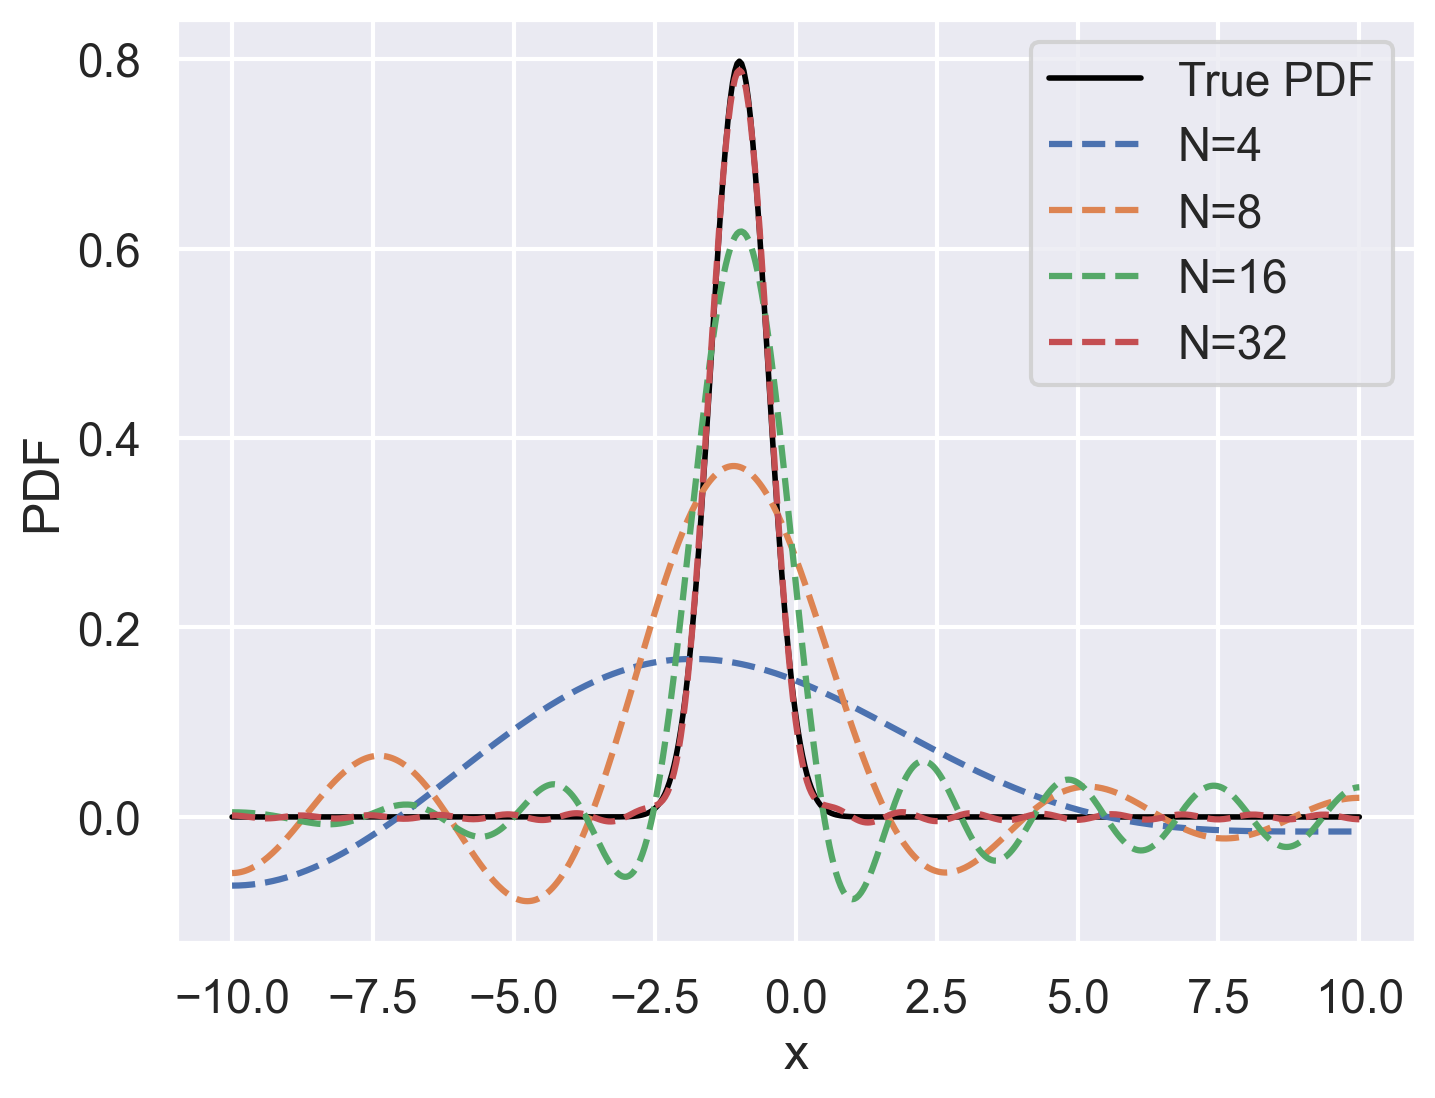

In [47]:
mu = -1.0
sigma = 0.5

fig, ax = plt.subplots()
ax.plot(x, pdf_normal(x, mu, sigma), label="True PDF", color="black", linewidth=2)
for N in [4, 8, 16, 32]:
    ax.plot(x, pdf_normal_cos_method(x, N, mu=mu, sigma=sigma), "--", label=f"N={N}")
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("PDF")
plt.show()

### Lognormal example

Let $Y = \exp(X)$ where $X \sim \mathcal{N}(\mu, \sigma^2)$.

The PDF of $Y$ is given by

$$
    f_Y(y) = \frac{1}{y} f_{X}(\log(y))
$$

In [ ]:
def pdf_lognormal(y, mu=0.0, sigma=1.0):
    """PDF of the lognormal distribution Y = exp(X) where X ~ N(mu, sigma^2)."""
    return stats.lognorm.pdf(y, s=sigma, scale=np.exp(mu))


def pdf_lognormal_cos_method(y, N, mu=0.0, sigma=1.0):
    """
    PDF of the lognormal distribution Y = exp(X) where X ~ N(mu, sigma^2)
    using the cosine method.
    """
    x = np.log(y)
    pdf_x = pdf_normal_cos_method(x, N, mu=mu, sigma=sigma)
    return pdf_x / y


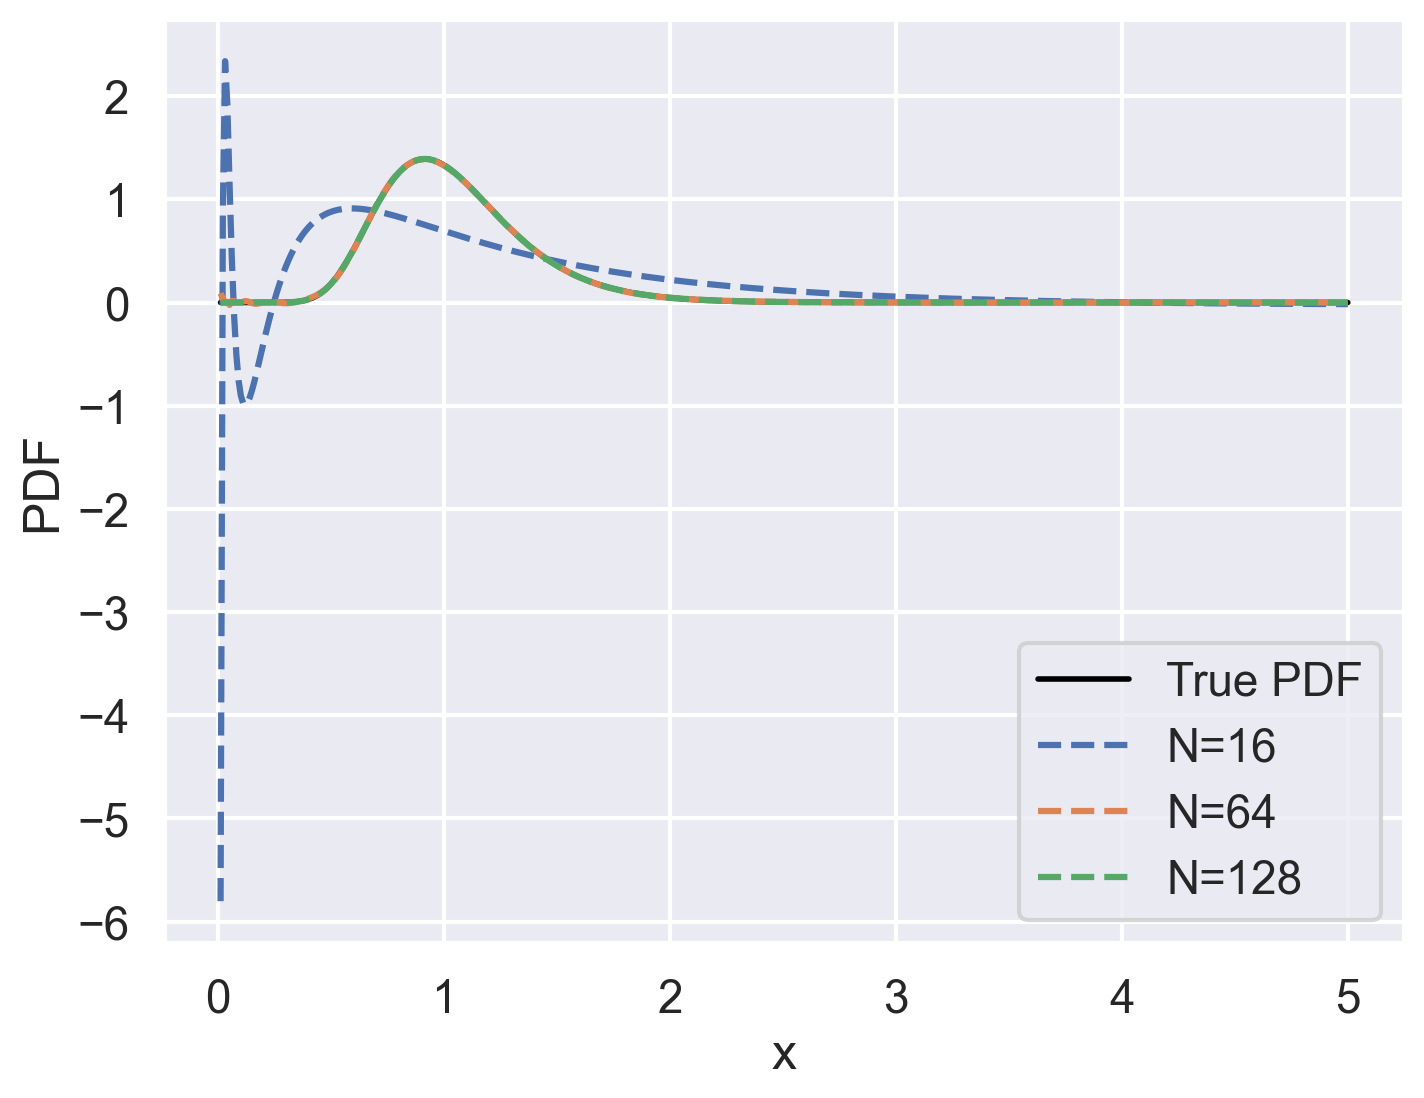

In [52]:
mu = 0.0
sigma = 0.3
ys = np.linspace(0.01, 5, 501)

fig, ax = plt.subplots()
ax.plot(
    ys,
    pdf_lognormal(ys, mu=mu, sigma=sigma),
    label="True PDF",
    color="black",
    linewidth=2,
)
for N in [16, 64, 128]:
    ax.plot(
        ys, pdf_lognormal_cos_method(ys, N, mu=mu, sigma=sigma), "--", label=f"N={N}"
    )
ax.legend()
ax.set_xlabel("x")
ax.set_ylabel("PDF")
plt.show()

### Pricing of European options